# A Parallel workflow LLM app
Here we are attempting to create a LLM application with parallel workflow. We will also use a shared list to simulate data contention.

### 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [2]:
# For graphical visualization of the state graph
 
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

### 2. Linking the model

In [3]:
model = ChatOllama(model="gemma:2b")

### 3. Creating a schema for a structured output
As we are expecting a text feedback and a numerical score, the output needs to be structured. Using the BaseModel and Field from pydantic we can declare the structure in which the LLM will have to answer. 

In [4]:
class Evaluation_Schema(BaseModel):
    feedback : str = Field(description="essay aspect review")
    score : int = Field(description="score out of 10", ge=0, le=10)

In [5]:
structured_model = model.with_structured_output(Evaluation_Schema)

### 4. Create a state

In [6]:
class EssayState(TypedDict):                                    # The AnswerState inherits a TypedDict
    essay       : str
    cot_fb      : str                                   # Clearity of thought feedback
    doa_fb      : str                                   # Depth of analysis feedback
    lng_fb      : str                                   # Language correctness feedback
    sum_fb      : str                                   # Summarised feedback
    """indiv_score : list[int]                              # Will be storing the the scores for each aspect. Will cause issues as parallel access of the list items even if the items are different will trigger a contention"""
    indiv_score : Annotated[list[int], operator.add]    # We are using this instead to process the list parallelly.
    sum_score   : int                                   # Intending it to be the sum of scores
    avg_score   : float

### 5. Define the function for the graph node

In [7]:
def find_clarity(state: EssayState) -> EssayState:
    prompt = f"Provide the feedback about clarity of thought for the following essay and score it from 0 to 10:\n\n {state['essay']}"
    output = structured_model.invoke(prompt)
    return { 'cot_fb' : output.feedback , 'indiv_score' : [output.score] }



def find_depth(state: EssayState) -> EssayState:
    prompt = f"Provide the feedback about depth of concept for the following essay and score it from 0 to 10:\n\n {state['essay']}"
    output = structured_model.invoke(prompt)
    return { 'doa_fb' : output.feedback , 'indiv_score' : [output.score] }



def find_correctness(state: EssayState) -> EssayState:
    prompt = f"Provide the feedback about correctness of words an language for the following essay and score it from 0 to 10:\n\n {state['essay']}"
    output = structured_model.invoke(prompt)
    return { 'lng_fb' : output.feedback , 'indiv_score' : [output.score] }



def summarize(state: EssayState) -> EssayState:
    prompt = f"Summarize the feedbacks on the following aspects:\n\n\n\n clarity of thought:\n {state['essay']} \n\n\n\n depth of knowledge:\n {state['essay']} \n\n\n\n Language correctness:\n {state['essay']}"
    output = model.invoke(prompt).content
    sum_sc = sum(state['indiv_score'])
    avg_sc = sum_sc/len(state['indiv_score'])
    return { 'sum_fb' : output, 'sum_score' : sum_sc, 'avg_score' : avg_sc }

### 6. Create the graph

In [8]:
# Declare the graph:
graph = StateGraph(EssayState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node("find_clarity", find_clarity)
graph.add_node("find_depth", find_depth)
graph.add_node("find_correctness", find_correctness)
graph.add_node("summarize", summarize)



# Add edges to the graph:
graph.add_edge(START, 'find_clarity')
graph.add_edge(START, 'find_depth')
graph.add_edge(START, 'find_correctness')

graph.add_edge('find_clarity', 'summarize')
graph.add_edge('find_depth', 'summarize')
graph.add_edge('find_correctness', 'summarize')

graph.add_edge('summarize', END)

### 7. Compile the graph

In [9]:
workflow = graph.compile()

### 8. The Graph

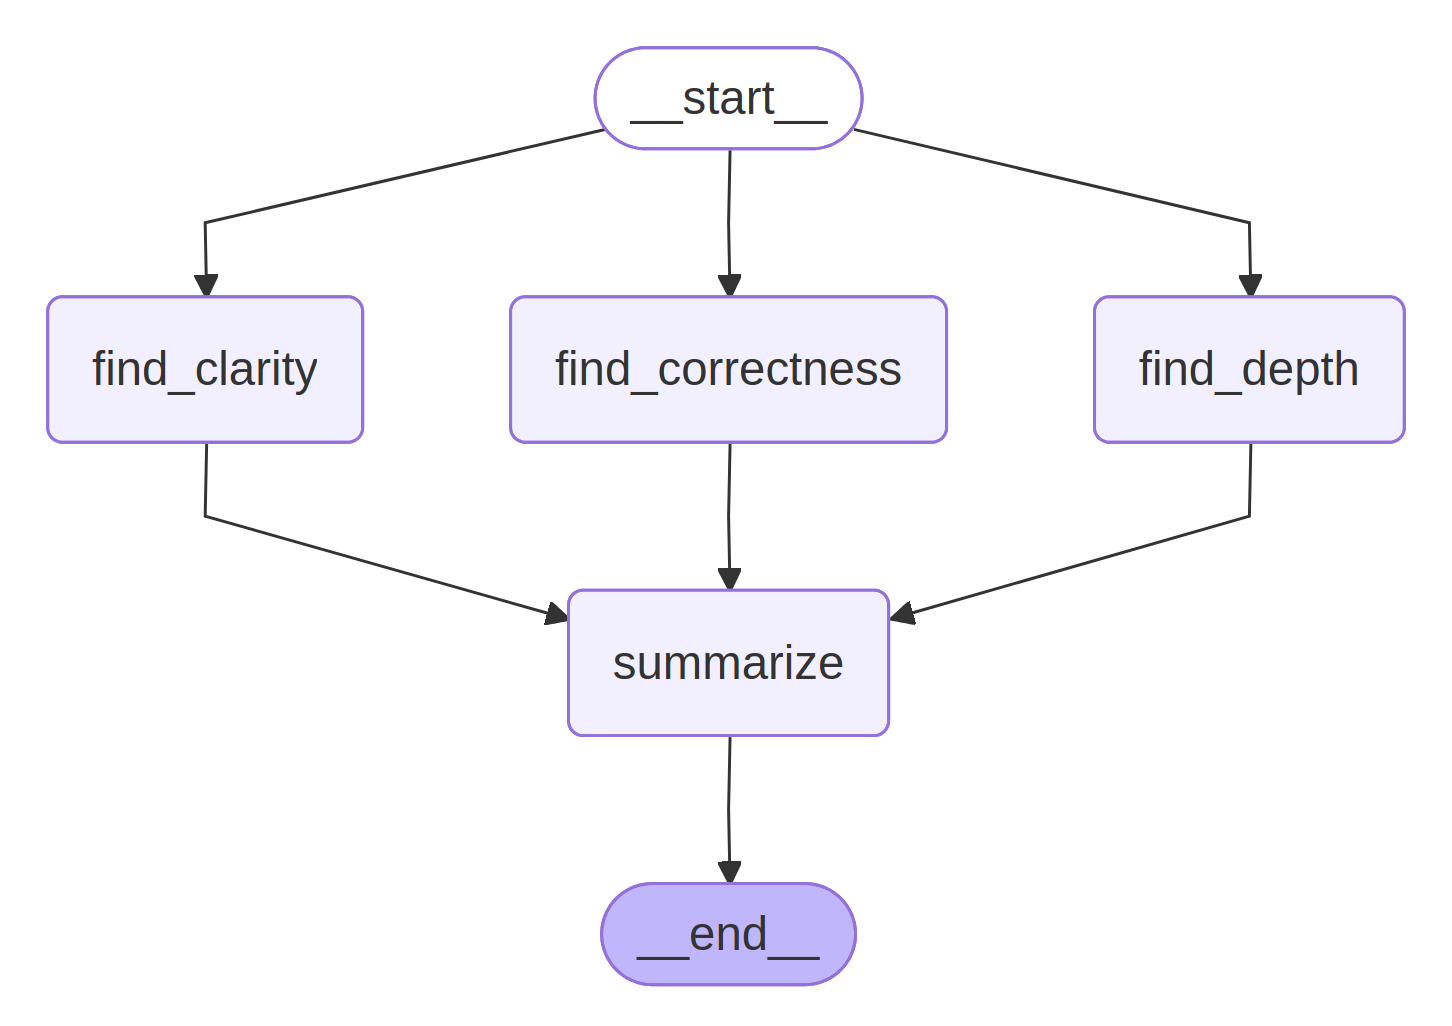

In [10]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

### 9. Run the code

In [11]:
input_essay = """ A tariff, fundamentally, is a tax imposed by a government on imported goods or services. Throughout history, these duties have served as critical instruments of protectionism, designed to shield domestic industries from foreign competition and, simultaneously, generate revenue for the state. While often championed as tools of national economic defense, the imposition of tariffs creates a complex web of consequences that impacts consumers, domestic producers, and global trade dynamics in both intended and unintended ways.

Tariffs generally manifest in two primary forms: a specific tariff, which is a fixed charge per unit of imported goods (e.g., $5 per barrel of oil), and an ad valorem tariff, which is a fixed percentage of the value of the imported good (e.g., a 10% tax on the price of an imported car). In theory, by increasing the cost of foreign products, tariffs make domestically produced goods comparatively cheaper and more appealing, thereby boosting local industry, employment, and production. This is the core argument of protectionists, who often advocate for tariffs to safeguard strategic industries, create an equitable "level playing field," or retaliate against unfair trade practices by other nations.

However, the positive outcomes for protected industries often come at a significant cost to the broader economy. The first group to feel the pain are consumers, who inevitably face higher prices. Since the tariff is an added cost, importers usually pass this burden onto the end buyer. This effect is often compounded when domestic producers, sensing less foreign competition, raise their own prices—a phenomenon that acts as a hidden, regressive tax on the population, especially for essential goods.

Beyond the domestic market, tariffs introduce distortions to global trade. They reduce the overall volume of trade by making imports less attractive, leading to a decline in efficiency as countries are forced to produce goods they are less suited for, rather than specializing based on comparative advantage. Crucially, the use of tariffs frequently invites retaliation. When one country imposes a tariff, trading partners often respond with their own counter-tariffs, escalating into trade disputes or "trade wars" that harm exporting industries on both sides, disrupting global supply chains and creating economic uncertainty. Ultimately, tariffs are a double-edged sword: they may offer short-term shelter to specific domestic sectors but often result in reduced economic efficiency, higher consumer costs, and instability in the interconnected global market."""

In [12]:
initial_state = { "essay" : input_essay }

final_state = workflow.invoke(initial_state)

print(final_state)


{'essay': ' A tariff, fundamentally, is a tax imposed by a government on imported goods or services. Throughout history, these duties have served as critical instruments of protectionism, designed to shield domestic industries from foreign competition and, simultaneously, generate revenue for the state. While often championed as tools of national economic defense, the imposition of tariffs creates a complex web of consequences that impacts consumers, domestic producers, and global trade dynamics in both intended and unintended ways.\n\nTariffs generally manifest in two primary forms: a specific tariff, which is a fixed charge per unit of imported goods (e.g., $5 per barrel of oil), and an ad valorem tariff, which is a fixed percentage of the value of the imported good (e.g., a 10% tax on the price of an imported car). In theory, by increasing the cost of foreign products, tariffs make domestically produced goods comparatively cheaper and more appealing, thereby boosting local industry,

In [13]:
print(final_state["cot_fb"])

The essay demonstrates a clear and logical approach to discussing the topic of tariffs. The writer provides a comprehensive overview of the subject, covering both the theoretical and practical aspects of tariffs. The essay is well-organized, with each paragraph focusing on a specific aspect of tariffs.


In [14]:
print(final_state["doa_fb"])

The essay demonstrates a good understanding of the concept of depth of concept and provides insightful analysis of the various aspects of tariffs.


In [15]:
print(final_state["lng_fb"])

The essay is well-written and provides a comprehensive overview of the topic. It effectively explains the concept of tariffs, their impacts on consumers, domestic producers, and global trade dynamics.


In [16]:
print(final_state["indiv_score"])

[8, 8, 8]


In [17]:
print(final_state["sum_fb"])

Sure, here is a summary of the feedbacks on the aspects discussed:

**Clarity of thought:**
* The passage is well-written and provides a clear and concise definition of a tariff.
* It also provides a comprehensive overview of the different forms that tariffs can take and the consequences they can have on consumers, domestic producers, and the global economy.

**Depth of knowledge:**
* The passage provides a good overview of the history of tariffs and their role in protectionism.
* It also discusses the complex web of consequences that tariffs can have on the economy, both intended and unintended.
* The passage also provides a clear and concise explanation of the arguments for and against tariffs.

**Language correctness:**
* The passage is free of grammatical errors and typos.
* It uses clear and concise language that is easy to understand.

Overall, the passage is well-written and provides a comprehensive overview of tariffs.


In [18]:
print(final_state["sum_score"])

24


In [19]:
print(final_state["avg_score"])

8.0
